<a href="https://colab.research.google.com/github/david-clistenes/http-portfolio/blob/main/codigo_aula23_classificacao_desbalanceada_ROC_AUC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação desbalanceada (Escolha do valor de limiar para classicação e cálculo das métricas ROC e AUC)

Esse notebook é uma tradução e adaptação do exemplo apresentado [no site do Keras](https://keras.io/examples/structured_data/imbalanced_classification/), criado por [fchollet](https://twitter.com/fchollet), e que utiliza essa base de dados do Kaggle [aqui](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud).


## Introdução

Este exemplo mostra como treinar um modelo classificador quando os dados são altamente desbalanceados. O objetivo é treinar uma rede neural capaz de identificar operações financeiras fraudulentas.

## Vetorizando os dados CSV

In [6]:
import csv
import numpy as np

# Os dados reais contendo operações financeiras pode ser obtido em https://www.kaggle.com/mlg-ulb/creditcardfraud/
fname = "creditcard.csv"

todas_caracteristicas = []
todos_rotulos         = []
with open(fname) as f:
    for i, line in enumerate(f):
        if i == 0: # primeira linha da tabela: cabeçalho
            print("CABECALHO:", line.strip())
            continue  # pula cabeçalho da tabela
        fields = line.strip().split(",")
        todas_caracteristicas.append([float(v.replace('"', "")) for v in fields[:-1]])
        todos_rotulos.append([int(fields[-1].replace('"', ""))])
        if i == 1:
            print("CARACTERISTICAS:", todas_caracteristicas[-1])

caracteristicas = np.array(todas_caracteristicas, dtype="float32")
valores_alvo    = np.array(todos_rotulos, dtype="uint8")
print("caracteristicas.shape:", caracteristicas.shape)
print("valores_alvo.shape:", valores_alvo.shape)

CABECALHO: "Time","V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","V16","V17","V18","V19","V20","V21","V22","V23","V24","V25","V26","V27","V28","Amount","Class"
CARACTERISTICAS: [0.0, -1.3598071336738, -0.0727811733098497, 2.53634673796914, 1.37815522427443, -0.338320769942518, 0.462387777762292, 0.239598554061257, 0.0986979012610507, 0.363786969611213, 0.0907941719789316, -0.551599533260813, -0.617800855762348, -0.991389847235408, -0.311169353699879, 1.46817697209427, -0.470400525259478, 0.207971241929242, 0.0257905801985591, 0.403992960255733, 0.251412098239705, -0.018306777944153, 0.277837575558899, -0.110473910188767, 0.0669280749146731, 0.128539358273528, -0.189114843888824, 0.133558376740387, -0.0210530534538215, 149.62]
caracteristicas.shape: (284807, 30)
valores_alvo.shape: (284807, 1)


## Preparando os dados

In [7]:
num_amostras_validacao = int(len(caracteristicas) * 0.2) # deixaremos 20% dos dados para validação
X_trein = caracteristicas[:-num_amostras_validacao]
y_trein = valores_alvo[:-num_amostras_validacao]
X_val   = caracteristicas[-num_amostras_validacao:]
y_val   = valores_alvo[-num_amostras_validacao:]

print("Número de amostras de treinamento:", len(X_trein))
print("Número de amostras de validação:", len(X_val))

Número de amostras de treinamento: 227846
Número de amostras de validação: 56961


## Análise do desbalanceamento nos rótulos e atribuição de pesos diferentes

In [8]:
qtdade_amostras_cada_classe = np.bincount(y_trein[:, 0]) # função do numpy que conta a quantidade de amostras para cada classe
print(qtdade_amostras_cada_classe)
print(
    "Número de amostras positivas no conjunto de dados: {} ({:.2f}% do total)".format(
        qtdade_amostras_cada_classe[1], 100 * float(qtdade_amostras_cada_classe[1]) / len(y_trein)
    )
)

peso_classe_0 = 1.0 / qtdade_amostras_cada_classe[0]
peso_classe_1 = 1.0 / qtdade_amostras_cada_classe[1]

print("Peso para classe 0:", peso_classe_0 )
print("Peso para classe 1:", peso_classe_1 )

pesos_classes = {0: peso_classe_0, 1: peso_classe_1} # cria um dicionário com o peso de cada classe

[227429    417]
Número de amostras positivas no conjunto de dados: 417 (0.18% do total)
Peso para classe 0: 4.396976638863118e-06
Peso para classe 1: 0.002398081534772182


## Normalizando os dados usando média e desvio padrão

In [12]:
media    = np.mean(X_trein, axis=0)
X_trein -= media
X_val   -= media
desvio   = np.std(X_trein, axis=0)
X_trein /= desvio
X_val   /= desvio

## Criando uma rede neural para classificação binária

In [13]:
import keras

modelo = keras.Sequential(
    [
        keras.Input(shape=X_trein.shape[1:]),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
modelo.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 256)                 │           7,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 139,777 (546.00 KB)

 Trainable params: 139,777 (546.00 KB)

 Non-trainable params: 0 (0.00 B)

## Treinando o modelo levando em conta o desbalaceamento entre as classes

In [14]:
modelo.compile(optimizer=keras.optimizers.Adam(1e-2), loss="binary_crossentropy")

modelo.fit(
    X_trein,
    y_trein,
    batch_size=2048, # define a quantidade de amostras de cada "mini-lote" (se comentarmos essa linha, será usado o padrão de 32 amostras por mini-lote)
    epochs=30,
    class_weight=pesos_classes,
)

Epoch 1/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 3.2347e-06
Epoch 2/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6241e-06
Epoch 3/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0684e-06
Epoch 4/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.1316e-07
Epoch 5/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.4490e-07
Epoch 6/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.7525e-07
Epoch 7/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.4594e-07
Epoch 8/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.9463e-07
Epoch 9/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0274e-06
Epoch 10/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.8165e-07
Epoch 11/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0905e-07
Epoch 12/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3940e-07
Epoch 13/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9009e-07
Epoch 14/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4240e-07


In [15]:
probabilidades = modelo.predict(X_val) # cálculo da saída da rede neural para as transações de validação

print(probabilidades.shape) # verificando o shape das probabilidades

print(probabilidades[:10])

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
(56961, 1)
[[9.80061837e-27]
 [3.61299018e-20]
 [6.49409573e-19]
 [6.12594819e-09]
 [2.71829545e-01]
 [1.51782953e-09]
 [7.72511726e-07]
 [1.32389826e-26]
 [8.26113462e-01]
 [1.00619106e-23]]


In [16]:
valor_limiar = 0.5

y_val_est = (probabilidades >= valor_limiar).astype(int)

print(y_val_est.shape)
print(y_val_est[:10])

(56961, 1)
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]]


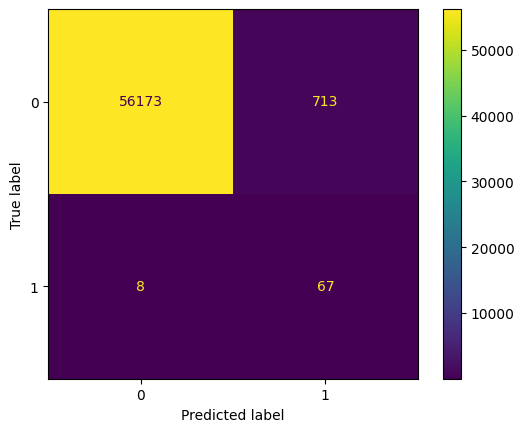

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val, y_val_est) # cm = confusion matrix = matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()


A partir da matriz de confusão, gerada para as transações de validação, podemos perceber que (os valores abaixo podem variar ligeiramente devido à inicialização aleatória dos pesos da rede neural):

- 56961 transações de validação foram avalidadas pela rede neural
- 66 transações foram corretamente identificadas como fraudulentas
- 8 transações fraudulentas não foram detectadas
- Infelizmente, 441 transações não fraudulentas foram incorretamente classificadas como fraudulentas.


Abaixo iremos construir uma função que permite calcular a matriz de confusão e suas métricas para diferentes valores de limiar

In [19]:
def calcula_metricas(probabilidades, valor_limiar=0.5):

  y_val_est = (probabilidades >= valor_limiar).astype(int)

  cm = confusion_matrix(y_val, y_val_est) # cm = confusion matrix = matriz de confusão

  # calculando métricas relativas à matriz de confusão

  # faremos os cálculos abaixo levando em conta apenas a classe y=1 como sendo a classe "positiva" (classe de referência)
  # Note que a posição dos elementos na matriz de confusão obtida pela função "confusion_matrix" do sk learn é diferente daquela apresentada nos slides da aula.
  vp = cm[1,1] # verdadeiros positivos
  vn = cm[0,0] # verdadeiros negativos
  fp = cm[0,1] # falsos positivos
  fn = cm[1,0] # falsos negativos

  precisao  = vp / (vp + fp)
  revocacao = vp / (vp + fn)
  f1_score  = 2*precisao*revocacao / (precisao + revocacao)
  taxa_VP   = revocacao
  taxa_FP   = fp / (fp + vn)

  return precisao, revocacao, f1_score, taxa_VP, taxa_FP

In [37]:
valor_limiar = 0.5

precisao, revocacao, f1_score, taxa_VP, taxa_FP = calcula_metricas(probabilidades, valor_limiar)

print("precisão: ", precisao)

print("recall: ", revocacao)

print("F1 score: ", f1_score)

print("taxa de VP: ", taxa_VP)

print("taxa de FP: ", taxa_FP)

precisão:  0.0858974358974359
recall:  0.8933333333333333
F1 score:  0.1567251461988304
taxa de VP:  0.8933333333333333
taxa de FP:  0.012533839609042646


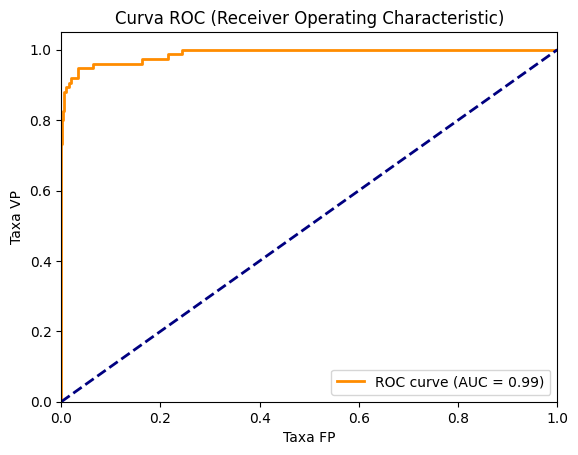

In [38]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_val, probabilidades) # já temos esses valores, portanto não precisamos recalculamos usando o SK-learn

roc_auc = auc(fpr, tpr)
# roc_auc = auc(taxa_FP, taxa_VP)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa FP')
plt.ylabel('Taxa VP')
plt.title('Curva ROC (Receiver Operating Characteristic)')
plt.legend(loc='lower right')
plt.show()

Note que é possível rodar a célula acima para diversos valores de limiar.

A célula abaixo faz isso sistematicamente.

In [35]:
valor_limiar = 0.8

precisao, revocacao, f1_score, taxa_VP, taxa_FP = calcula_metricas(probabilidades, valor_limiar)

print("precisão: ", precisao)

print("recall: ", revocacao)

print("F1 score: ", f1_score)

print("taxa de VP: ", taxa_VP)

print("taxa de FP: ", taxa_FP)

precisão:  0.12429378531073447
recall:  0.88
F1 score:  0.21782178217821782
taxa de VP:  0.88
taxa de FP:  0.008174243223288682


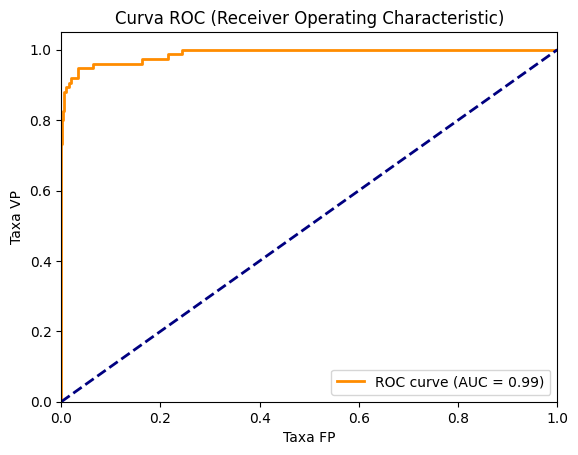

In [36]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_val, probabilidades) # já temos esses valores, portanto não precisamos recalculamos usando o SK-learn

roc_auc = auc(fpr, tpr)
# roc_auc = auc(taxa_FP, taxa_VP)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa FP')
plt.ylabel('Taxa VP')
plt.title('Curva ROC (Receiver Operating Characteristic)')
plt.legend(loc='lower right')
plt.show()

In [4]:
valor_limiar = 0.3

precisao, revocacao, f1_score, taxa_VP, taxa_FP = calcula_metricas(probabilidades, valor_limiar)

print("precisão: ", precisao)

print("recall: ", revocacao)

print("F1 score: ", f1_score)

print("taxa de VP: ", taxa_VP)

print("taxa de FP: ", taxa_FP)

NameError: name 'calcula_metricas' is not defined

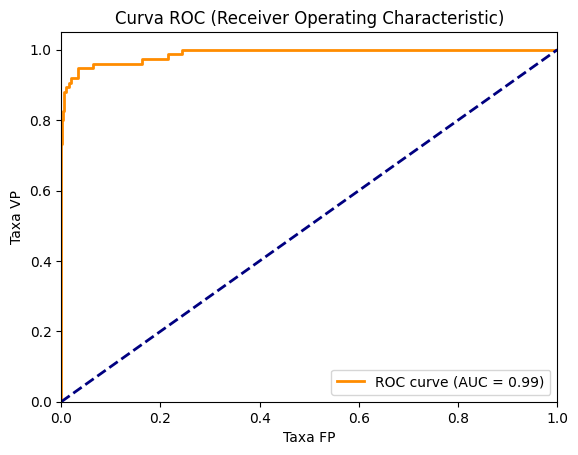

In [34]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_val, probabilidades) # já temos esses valores, portanto não precisamos recalculamos usando o SK-learn

roc_auc = auc(fpr, tpr)
# roc_auc = auc(taxa_FP, taxa_VP)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa FP')
plt.ylabel('Taxa VP')
plt.title('Curva ROC (Receiver Operating Characteristic)')
plt.legend(loc='lower right')
plt.show()

In [30]:
passo = 0.02 # define o passo de incremento do valor de limiar
valores_limiar = np.arange(0, 1+passo, passo) # define valores de limiar de 0 a 1 crescendo no passo pré-estabelecido
taxas_VP = []
taxas_FP = []

linhas = []

for valor_limiar in valores_limiar:
  precisao, revocacao, f1_score, taxa_VP, taxa_FP = calcula_metricas(probabilidades, valor_limiar)
  linha = {'Valor limiar': valor_limiar, 'Taxa de VP': taxa_VP, 'taxa de FP': taxa_FP}
  linhas.append(linha)


# Abaixo nós transformamos a lista acima num pandas dataframe

import pandas as pd

# Cria um DataFrame a partir da lista que contém as linhas da tabela
df = pd.DataFrame(linhas)

# Mostra o DataFrame resultante
# print(df)

# Mostra o DataFrame resultante sem omitir linhas
pd.set_option('display.max_rows', None)
print(df)

    Valor limiar  Taxa de VP  taxa de FP
0           0.00    1.000000    1.000000
1           0.02    0.920000    0.028460
2           0.04    0.920000    0.024470
3           0.06    0.920000    0.022554
4           0.08    0.920000    0.021306
5           0.10    0.920000    0.020603
6           0.12    0.906667    0.019688
7           0.14    0.906667    0.019020
8           0.16    0.906667    0.018388
9           0.18    0.906667    0.017843
10          0.20    0.906667    0.017350
11          0.22    0.906667    0.016964
12          0.24    0.906667    0.016542
13          0.26    0.906667    0.016208
14          0.28    0.906667    0.015891
15          0.30    0.906667    0.015698
16          0.32    0.893333    0.015382
17          0.34    0.893333    0.015030
18          0.36    0.893333    0.014626
19          0.38    0.893333    0.014327
20          0.40    0.893333    0.014028
21          0.42    0.893333    0.013835
22          0.44    0.893333    0.013483
23          0.46

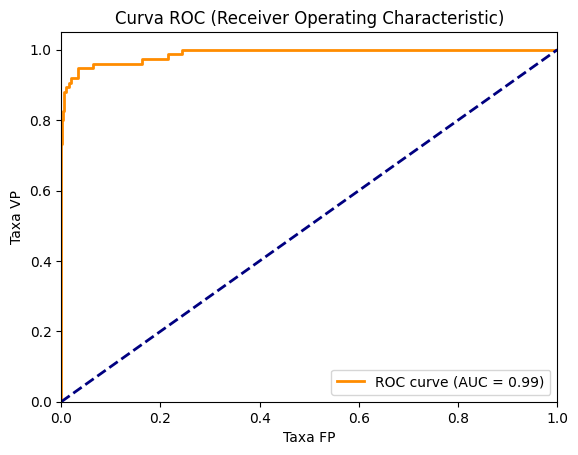

In [31]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_val, probabilidades) # já temos esses valores, portanto não precisamos recalculamos usando o SK-learn

roc_auc = auc(fpr, tpr)
# roc_auc = auc(taxa_FP, taxa_VP)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa FP')
plt.ylabel('Taxa VP')
plt.title('Curva ROC (Receiver Operating Characteristic)')
plt.legend(loc='lower right')
plt.show()

In [3]:
# prompt: de acordo com os resultados dos códigos acima, comparando os diferentes valores de limiar e os resultados encontrados com as variações implementadas, como diferentes valores de limiar afetam as taxas de VP e FP
# resultantes para os dados de valida¸c˜ao deste problema, escolha um valor de limiar adequado. Justifique e
# detalhe sua escolha final

import pandas as pd

# Assuming 'df' from the provided code is available

# Analyze the DataFrame to find a suitable threshold
# Look for a balance between high True Positive Rate (TPR) and low False Positive Rate (FPR)

# Example: Find the threshold that maximizes the difference between TPR and FPR
best_threshold = df.loc[(df['Taxa de VP'] - df['taxa de FP']).idxmax()]

print(f"Best Threshold: {best_threshold['Valor limiar']}")
print(f"Corresponding TPR: {best_threshold['Taxa de VP']}")
print(f"Corresponding FPR: {best_threshold['taxa de FP']}")

# Justification:
# The code finds the threshold that maximizes the difference between the true positive rate
# and the false positive rate. This indicates a point on the ROC curve where the model is most effective in
# distinguishing between the classes while minimizing the number of incorrect positive predictions.
# This is often a good practical threshold because it provides a balance between capturing the positive class
# and avoiding excessive false positives. Other possible metrics to consider are F1 score, which balances
# precision and recall, and Youden's index, which directly considers TPR and FPR.

# Further analysis might include plotting the TPR vs. FPR to visually identify a desirable operating point.
# For example, if false positives are very costly, you might choose a point with a very low FPR, even at the
# expense of a slightly lower TPR.  Conversely, if it is important to detect all positives, then a higher TPR
# would be preferred, even at the cost of more false positives.  The 'best' threshold thus depends on the
# particular application and its tolerance for different types of errors.

NameError: name 'df' is not defined

In [2]:
import pandas as pd

# Assuming 'df' is the DataFrame created in the previous code cell
# Find the threshold that maximizes the true positive rate while minimizing the false positive rate

# Method 1:  Prioritize high True Positive Rate (Recall)
# Find the threshold with the highest true positive rate (recall), then select the lowest corresponding false positive rate
best_recall_index = df['Taxa de VP'].idxmax()
best_recall_threshold = df.loc[best_recall_index, 'Valor limiar']
best_recall_fpr = df.loc[best_recall_index, 'taxa de FP']

print(f"Method 1 (Best Recall):\nThreshold: {best_recall_threshold}, False Positive Rate: {best_recall_fpr}, True Positive Rate: {df['Taxa de VP'].max()}")

# Method 2: Balance between True Positive and False Positive Rates
# Find the point on the ROC curve that is closest to the top-left corner (100% True Positive Rate and 0% False Positive Rate)

# We can use the Euclidean distance to find this point.
df['distance_from_top_left'] = (1-df['Taxa de VP'])**2 + (df['taxa de FP'])**2
best_distance_index = df['distance_from_top_left'].idxmin()
best_distance_threshold = df.loc[best_distance_index, 'Valor limiar']
best_distance_tpr = df.loc[best_distance_index, 'Taxa de VP']
best_distance_fpr = df.loc[best_distance_index, 'taxa de FP']

print(f"Method 2 (Best Balance):\nThreshold: {best_distance_threshold}, False Positive Rate: {best_distance_fpr}, True Positive Rate: {best_distance_tpr}")


# Justification:
# The choice of threshold depends on the specific needs of the application.
# If minimizing false positives is critical (e.g., avoid incorrectly flagging legitimate transactions as fraudulent), prioritize a lower threshold as done in Method 1.
# If maximizing true positives is the priority (e.g., catch as many fraudulent transactions as possible, even at the cost of some false positives), prioritize a higher threshold.

# Based on these methods and considering the context of fraud detection, a balanced approach (Method 2) is generally preferred. It aims to find a point on the ROC curve that is closer to ideal (high true positives, low false positives).
# The selected threshold (using Method 2) will provide a reasonable trade-off between detecting fraudulent transactions and minimizing incorrect classifications of legitimate transactions.
# However, a domain expert should always validate this automated selection.

NameError: name 'df' is not defined